# Converting the VIPER dataset to a KITTI Structure
We want to extract as much meaningful images as possible from the VIPER dataset and convert them to the KITTI dataset structure.

### Structure
The VIPER dataset is split into training, validation, and test set. 
Each subset is further divided into a number of video sequences. Each video
sequence was recorded in 1 of 5 environmental conditions (day, sunset, rain, 
night, snow). The frame rate of each sequence is approximately 15 fps.

### Input images (img)
Each image was recorded in 1080p (1920x1080 pixels). Due to the large number of 
frames, we provide the images in lossy JPG and lossless PNG format. 

### 2D/3D Bounding boxes (bb)
We provide bounding boxes in 2D (on the image plane) and in 3D 
(in camera coordinate frame) for a subset of the semantic classes. The 
annotations are stored as one CSV file per frame. Each row in one of the files
corresponds to a single object instance. The format for the columns is
classID, instanceID, 2D bounding box (4 values), 3D bounding box in model 
coordinate frame (6 values), matrix to transform 3D bounding box into camera 
coordinate frame (16 values).
An example for visualizing the bounding boxes for one frame is given in 
'drawBoundingBox.m'.



## Import Modules

In [206]:
from imageio import imread as imread, imwrite    # Read and write images
from skimage.transform import resize             # Resize images
import cv2
import os                                        # Use to list all the files in a folder
import os.path as path                           # System paths management
import json                                      # Save intermediary files
import tqdm                                      # To create the progress bar

# Optional but needed if you want to test the import of labels
from random import sample                        # randomly select some items in a list
from kittipy import display_im                   # https://github.com/LucasVandroux/KittiPy/releases/tag/v1.0
%matplotlib inline

## Global Variables

In [198]:
# Weather conditions to extract
list_weather = ['snow']    # Default: ['day', 'sunset', 'night', 'rain', 'snow']

# Label extraction variables
org_img_dim = [1080, 1920, 3]   # size original image
res_img_dim = [699, 1242, 3]    # size resized image
kit_img_dim = [375, 1242, 3]    # Size KITTI image

crop_y = [84, 84 + 375]      # Cropping position on the y axis

min_obj_height = 25          # min height to consider object as object of interest
max_ratio = 1.5              # max ratio for Car, Truck, Van and Tram to remove too occluded object
min_ratio = 0.65             # min ratio for pedestrian to remove head of drivers

interval = 8                 # min interval between two images
# Classes information
path_classes = '/Volumes/BLUE_TRANS/gta_dataset/readme/classes.csv'  # https://storage.googleapis.com/playing-for-benchmarks-download/readme.zip

# Export path + file_name for JSON file containing all the labels
export_json_file = '/Users/lucas/Desktop/label_exported.json'

# Export folder for new dataset
name_export_folder = 'gta_dataset_export'
path_export_folder = '/Users/lucas/Desktop'

# Training folder
t_path_weather = '/Volumes/BLUE_TRANS/gta_dataset/train/weather.txt'   # https://drive.google.com/uc?id=1fJTx6-bfKYQs1CQD1yh7RsTIjhR3n0y0&export=download
t_path_labels = '/Volumes/BLUE_TRANS/gta_dataset/train/bb'             # https://drive.google.com/uc?id=1r9xZmfAT75geV2ieotND4U7OMbBkp2OQ&export=download
t_path_img = '/Volumes/BLUE_TRANS/gta_dataset/train/img'

# Validation folder (Optional: but can be used to get even more images)
use_val_sets = True                                           
v_path_weather = '/Volumes/BLUE_TRANS/gta_dataset/val/weather.txt'     # https://drive.google.com/uc?id=1IDohh9gmdKKHvlixzsxKM_HAMKcl78Kg&export=download
v_path_labels = '/Volumes/BLUE_TRANS/gta_dataset/val/bb'               # https://drive.google.com/uc?id=1OSL9TIJNr-HNeNuTvxeejsrxuu__anOM&export=download
v_path_img = '/Volumes/BLUE_TRANS/gta_dataset/val/img'

### Correspondances between VIPER classes and KITTI classes
- We ignore all the classes that don't exist in the KITTI's classes (e.g. sidewalk, trafficsign).
- In KITTI buses, motorcycles and trailer are considered as MISC (see 00098.png).
- In VIPER the class Person_sitting doesn't exist.

In [187]:
# Correspondance between KITTI classes and GTA classses
classes_corres = {
    'Car': ['car'],
    'Van': ['van'],
    'Truck': ['truck'],
    'Pedestrian': ['person'],
    'Person_sitting': [],
    'Cyclist': ['bicycle'],
    'Tram': ['train'],
    'Misc': ['motorcycle', 'bus', 'trailer', 'animal'],
    'DontCare': ['ambiguous'],
    'Ignore': ['unlabeled', 'sky', 'road', 'sidewalk', 'railtrack',\
               'terrain', 'tree', 'vegetation', 'building',\
               'infrastructure', 'fence', 'billboard', 'trafficlight',\
               'trafficsign', 'mobilebarrier', 'firehydrant', 'chair',\
               'trash', 'trashcan', 'plane', 'boat']
}

# Inverse classes_corres
gta2kitti = {}
for k, v_list in classes_corres.items():
    if not k == 'Ignore': # remove 'Ignore' classes
        for v in v_list:
            gta2kitti[v] = k

print(json.dumps(gta2kitti, indent=2))

{
  "trailer": "Misc",
  "train": "Tram",
  "bus": "Misc",
  "bicycle": "Cyclist",
  "ambiguous": "DontCare",
  "car": "Car",
  "person": "Pedestrian",
  "van": "Van",
  "animal": "Misc",
  "motorcycle": "Misc",
  "truck": "Truck"
}


## Function to Import Sets' Name Based on Selected Weather Conditions

In [188]:
def import_sets_name(path_weather_file, list_weather):
    # Initialized dict to store weather information per folder
    weather_dict = {w: [] for w in list_weather}

    # File Organization [id_set, weather]:
    with open(path_weather_file) as f:
        for line in f:
            # Parse line
            line_parsed = line.strip().split(',')

            # Fill the dictionary with the values
            if line_parsed[1] in weather_dict.keys():
                weather_dict[line_parsed[1]].append(line_parsed[0])
    
    return weather_dict         

## Function to Import Classes ID

In [189]:
def import_classes_id(path_classes_file, gta2kitti, classes_corres):
    # Extract correspondance between id and classname in the classes.csv
    id2class = {}
    
    with open(path_classes_file) as f:
        for line in f:
            # Parse line
            line_parsed = line.strip().split(',')

            if not line_parsed[0] == 'id': # Ignore header
                id2class[line_parsed[0]]= line_parsed[1]

    # Create dictionnary to extract future classes from GTA dataset
    classes_dict = {k:{'kitti': gta2kitti[v], 'gta': v} for k, v in id2class.items() if not v in classes_corres['Ignore']}        
    
    return classes_dict

## Functions to Import Labels
KITTI classification of objects: 
 - __Easy__: Min. bounding box height: 40 Px, Max. occlusion level: Fully visible, Max. truncation: 15 %
 - __Moderate__: Min. bounding box height: 25 Px, Max. occlusion level: Partly occluded, Max. truncation: 30 %
 - __Hard__: Min. bounding box height: 25 Px, Max. occlusion level: Difficult to see, Max. truncation: 50 %

Notes:
 - To consider an image worth analysing it should contains at least 1 Car or Cyclist or Pedestrian object.
 - We relabel too small objects as DontCare to avoid penalizing the future algorithm is they detect it anyway.

In [190]:
def extract_labels(path_labels_file, classes_dict, org_img_dim, res_img_dim, kit_img_dim, crop_y, min_obj_height, max_ratio, min_ratio):
    img_dim1 = org_img_dim
    img_dim2 = res_img_dim
    cy_min = crop_y[0]               
    kitti_dimy =  kit_img_dim[0]
    
    labels_list = []
    contains_oi = False # Contains at least 1 Object of interest
    
    # File Organization [id_set, weather]:
    with open(path_labels_file) as f:
        for line in f:
            # Parse line
            line_p = line.strip().split(',')

            class_id = line_p[0]
            x_min = int(int(line_p[2]) * img_dim2[1] / img_dim1[1])
            y_min = max(0, int(int(line_p[3]) * img_dim2[0] / img_dim1[0]) - cy_min)
            x_max = int(int(line_p[4]) * img_dim2[1] / img_dim1[1])
            y_max = min(kitti_dimy, int(int(line_p[5]) * img_dim2[0] / img_dim1[0]) - cy_min)
    
            if class_id in classes_dict.keys() and y_min <= kitti_dimy:
                height = y_max - y_min
                width = x_max - x_min
                ratio = height / (width + 0.00000001)
                
                class_name = classes_dict[class_id]['kitti']
                
                if class_name == 'Pedestrian' and ratio < min_ratio:
                    # Pedestrian have too weird ratio (probably drivers)
                    class_name = 'DontCare'
                
                elif ratio > max_ratio and not class_name in ['Pedestrian', 'Cyclist']:
                    # Object are too much occluded
                    class_name = 'DontCare'
                    
                elif height < min_obj_height:
                    # Keep the object but set is as DontCare
                    class_name = 'DontCare'
                
                if class_name in ['Pedestrian', 'Cyclist', 'Car']:
                    contains_oi = True
                    
                labels_list.append(
                    {'type': class_name, 'bbox':{
                        'x_min': x_min,
                        'y_min': y_min,
                        'x_max': x_max,
                        'y_max': y_max}
                    }
                )
            
    return labels_list, contains_oi

In [191]:
def extract_labels_from_folder(set_name, lbl_folder_path, classes_dict, interval, org_img_dim, res_img_dim, kit_img_dim, crop_y, min_obj_height, max_ratio, min_ratio):
    list_img_labels = []
    
    # print('Analysing \'' + lbl_folder_path + '\':')
    list_lbl = [lbl_name for lbl_name in os.listdir(lbl_folder_path) if lbl_name.lower().endswith('.csv') and not lbl_name.startswith('.')]
    list_lbl.sort()
    num_lbl = len(list_lbl)
    # print(' \'-> ' + str(num_lbl) + ' .csv found')
    
    idx = 3 # Keep 3 images before to extract them later
    
    while idx < num_lbl:
        lb_path = path.join(lbl_folder_path, list_lbl[idx])
        labels, contains_oi = extract_labels(lb_path, classes_dict, org_img_dim, res_img_dim, kit_img_dim, crop_y, min_obj_height, max_ratio, min_ratio) 
        
        if contains_oi:
            img_name =  list_lbl[idx][:-4] + '.png'
            list_img_labels.append({'filename': img_name, 'bboxes': labels, 'set': set_name})
            idx += interval
        
        else:
            idx += 1
    
    return list_img_labels

# Import Labels

In [192]:
# Check if using validation sets
print('-> Use Validation Sets: ' + str(use_val_sets))

# --- WEATHER ---
# Import sets according to weather conditions
weather_dict = {}
weather_dict['train'] = import_sets_name(t_path_weather, list_weather)
if use_val_sets:
    weather_dict['val'] = import_sets_name(v_path_weather, list_weather)

# Print repartition of the weather conditions
print('-> Count Sets per Weather:')
count_sets_per_weather = {w: 0 for w in ['day', 'sunset', 'night', 'rain', 'snow']}
for _, rep_weather in weather_dict.items():
    for weather, list_sets in rep_weather.items():
        count_sets_per_weather[weather] += len(list_sets)
print(count_sets_per_weather)

# --- CLASSES ---
# Import Classes ID
classes_dict = import_classes_id(path_classes, gta2kitti, classes_corres)

# Print classes correspondance
print('-> Classes Correspondance:')
for class_id, class_info in classes_dict.items():
    print(' - ' + class_info['gta'] + '[id:' + class_id + '] = ' + class_info['kitti'])
    
# --- LABELS ---
labels = []
# Importing labels from training folder
list_train_folders = [folder_name for list_folders in weather_dict['train'].values() for folder_name in list_folders]
print('-> [TRAIN] Extracting labels from ' + str(len(list_train_folders)) + ' folders:')
for idx in tqdm.trange(len(list_train_folders), ascii = True):
    lbl_folder_path = path.join(t_path_labels, '0' + list_train_folders[idx])
    labels_in_folder = extract_labels_from_folder('train', lbl_folder_path, classes_dict, interval, org_img_dim, res_img_dim, kit_img_dim, crop_y, min_obj_height, max_ratio, min_ratio)
    labels = labels + labels_in_folder

num_train_img = len(labels)
print(' \'-> Imported labels for ' + str(num_train_img) + ' images.')
    
# Importing labels from validation folder
if use_val_sets:
    list_val_folders = [folder_name for list_folders in weather_dict['val'].values() for folder_name in list_folders]
    print('-> [VAL] Extracting labels from ' + str(len(list_val_folders)) + ' folders:')
    for idx in tqdm.trange(len(list_val_folders), ascii = True):
        lbl_folder_path = path.join(v_path_labels, '0' + list_val_folders[idx])
        labels_in_folder = extract_labels_from_folder('val', lbl_folder_path, classes_dict, interval, org_img_dim, res_img_dim, kit_img_dim, crop_y, min_obj_height, max_ratio, min_ratio)
        labels = labels + labels_in_folder

num_val_img = len(labels) - num_train_img
print(' \'-> Imported labels for ' + str(num_val_img) + ' images.')

# --- SAVE EXPORT ---
print('-> Saving labels to disk...')
with open(export_json_file, 'w') as outfile:
    json.dump(labels, outfile)

print(' \'-> File saved to ' + export_json_file)

-> Use Validation Sets: True
-> Count Sets per Weather:
{'sunset': 0, 'rain': 0, 'day': 0, 'night': 0, 'snow': 20}
-> Classes Correspondance:
 - van[id:25] = Van
 - animal[id:21] = Misc
 - motorcycle[id:23] = Misc
 - bicycle[id:22] = Cyclist
 - ambiguous[id:1] = DontCare
 - train[id:29] = Tram
 - person[id:20] = Pedestrian
 - trailer[id:28] = Misc
 - bus[id:26] = Misc
 - truck[id:27] = Truck
 - car[id:24] = Car


  0%|          | 0/12 [00:00<?, ?it/s]

-> [TRAIN] Extracting labels from 12 folders:


  0%|          | 0/8 [00:00<?, ?it/s]

 '-> Imported labels for 2056 images.
-> [VAL] Extracting labels from 8 folders:


100%|##########| 8/8 [00:12<00:00,  1.55s/it]


 '-> Imported labels for 862 images.
-> Saving labels to disk...
 '-> File saved to /Users/lucas/Desktop/label_exported.json


### Test the labels by displaying some images

023_00260.png[val]:


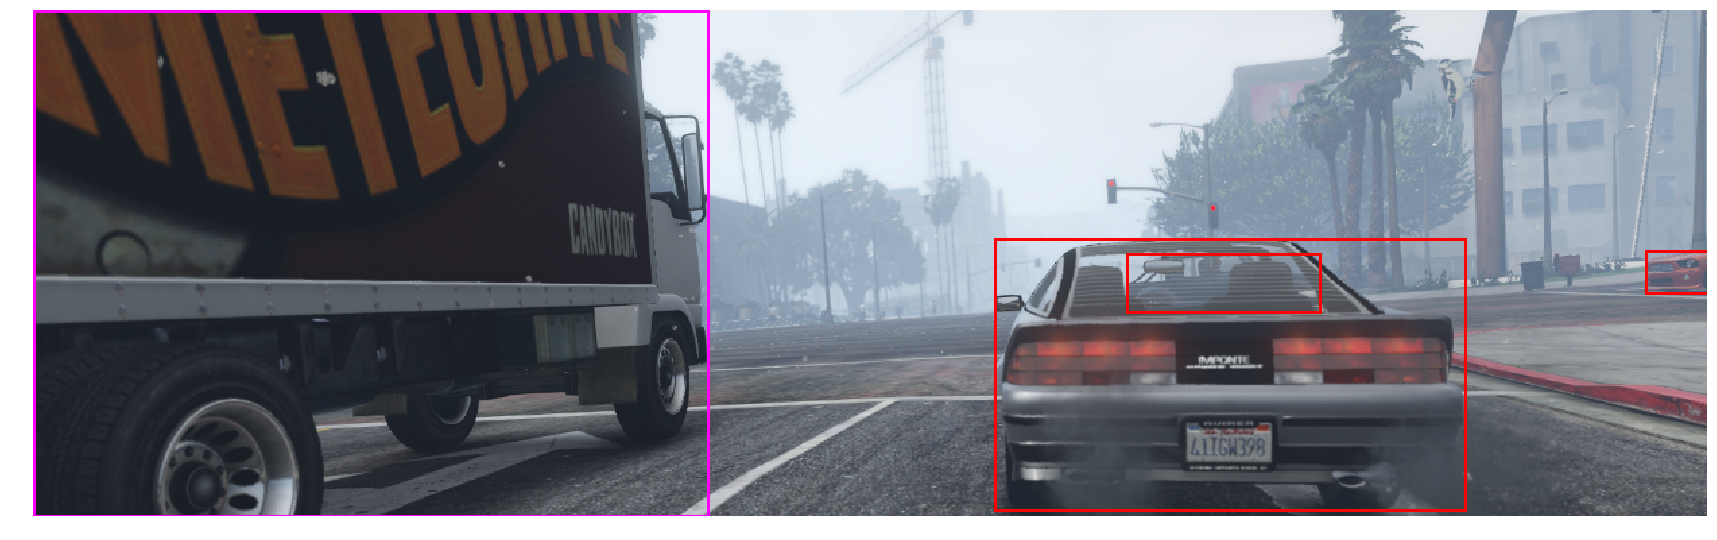

024_00069.png[val]:


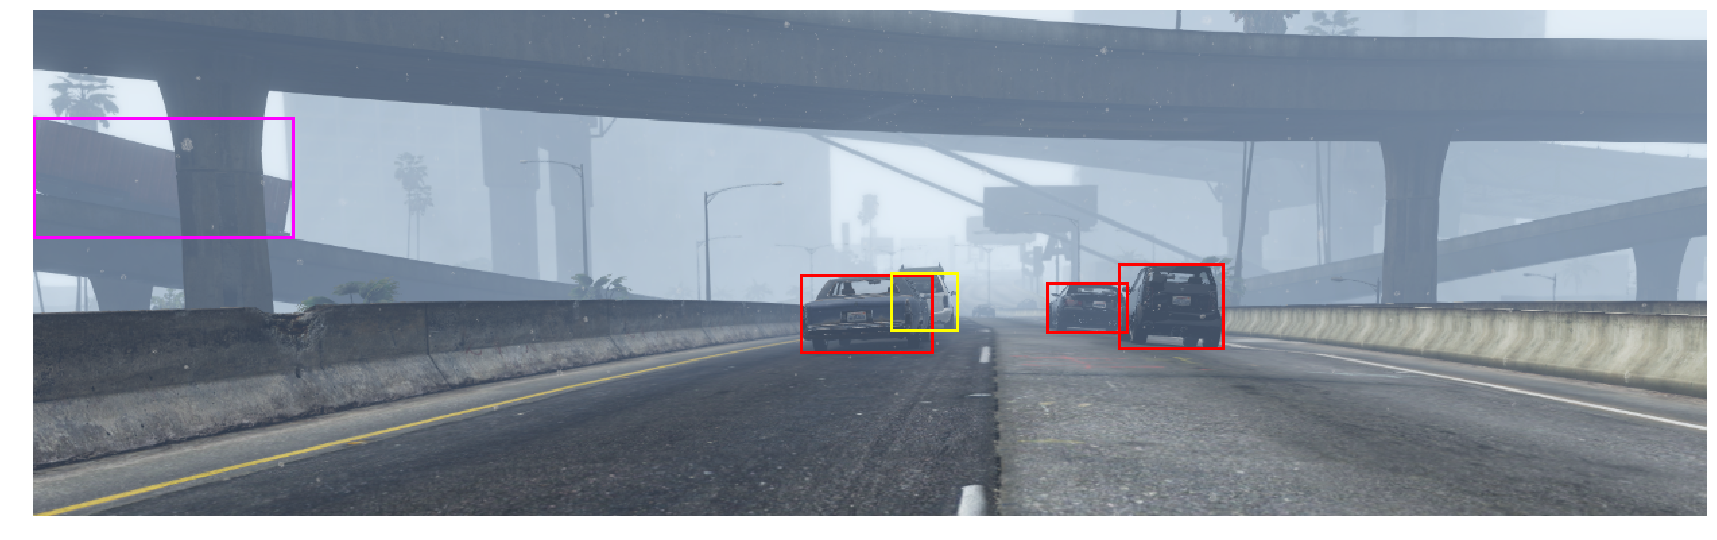

022_00748.png[val]:


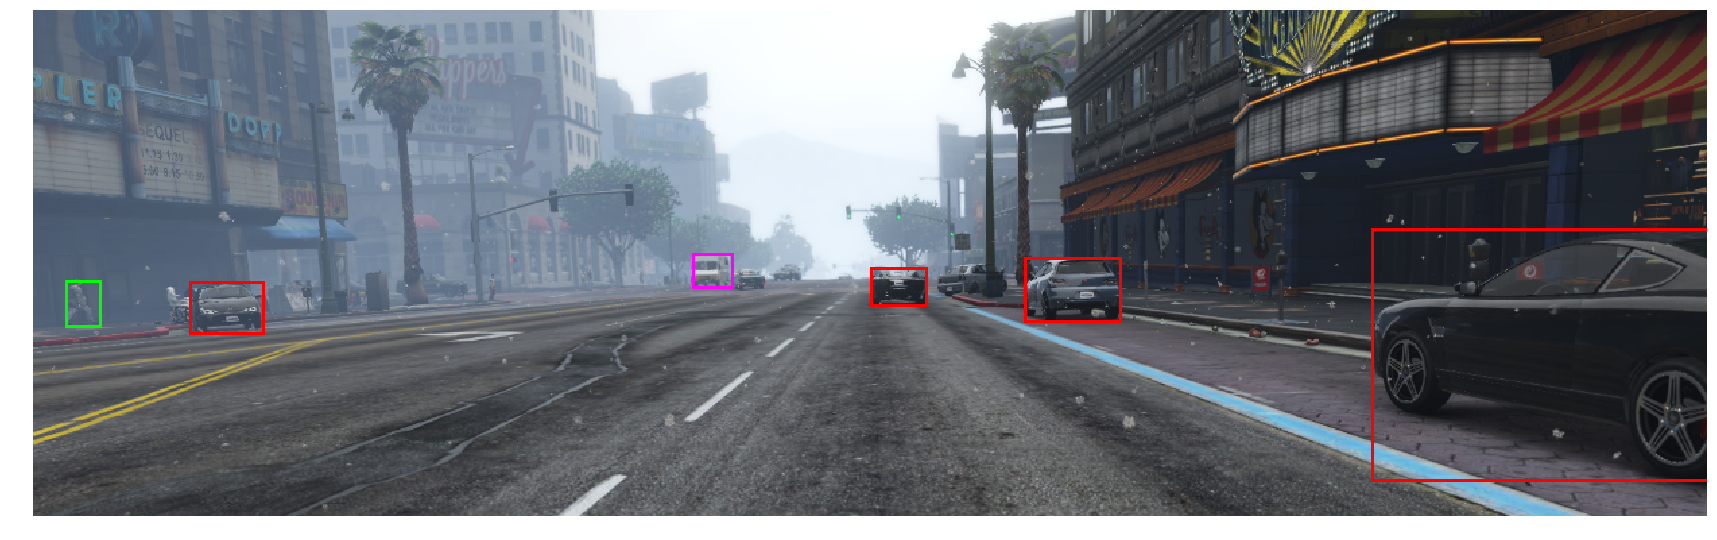

021_00228.png[val]:


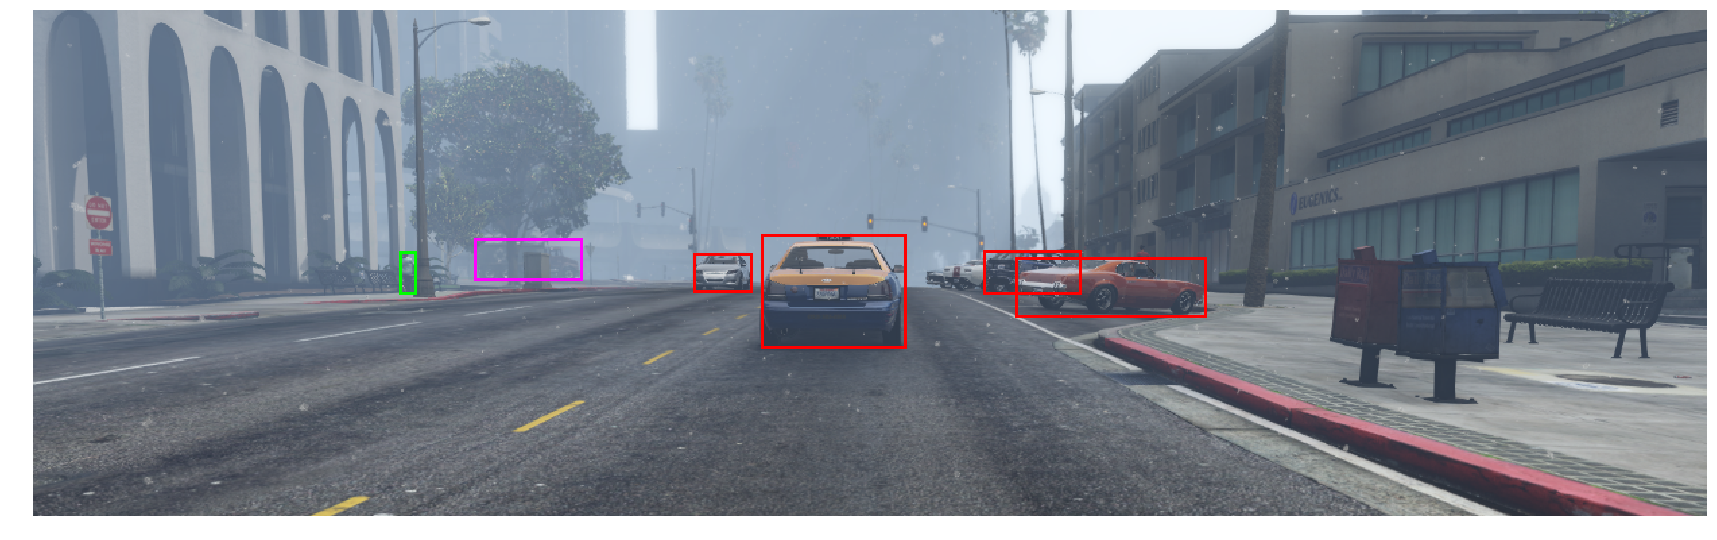

022_00724.png[val]:


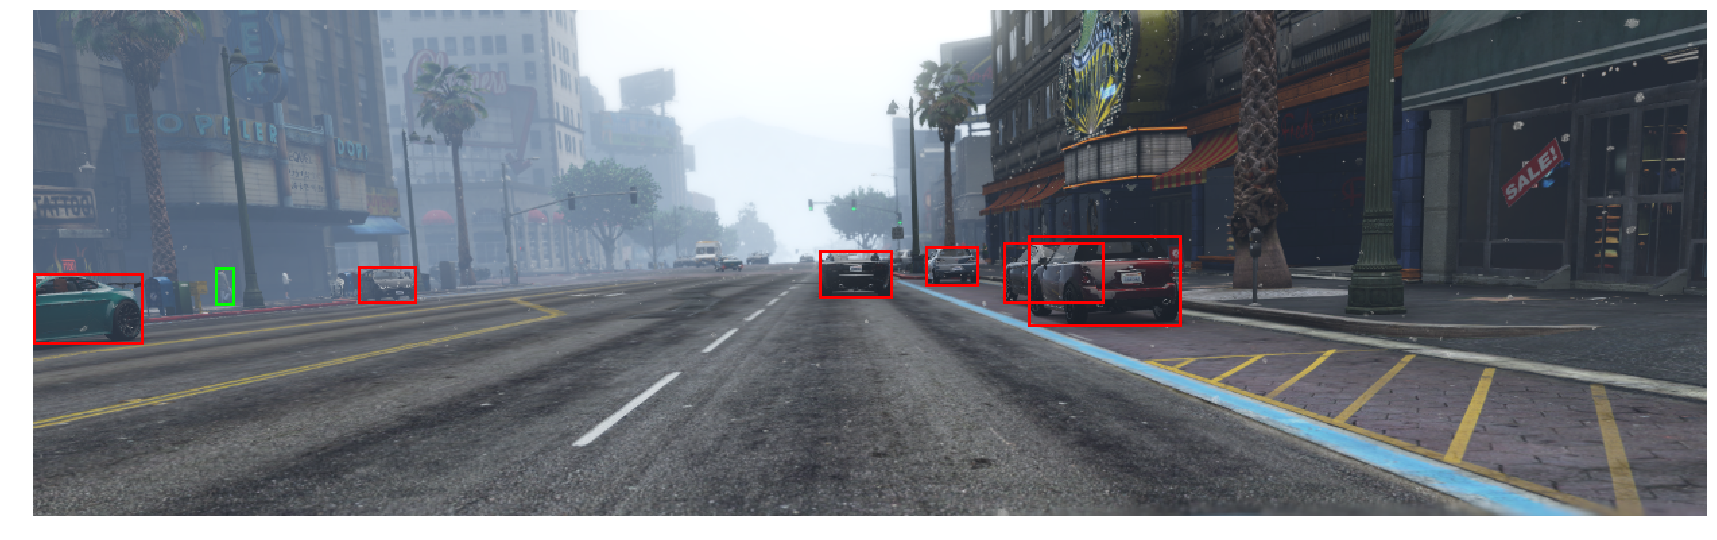

021_00484.png[val]:


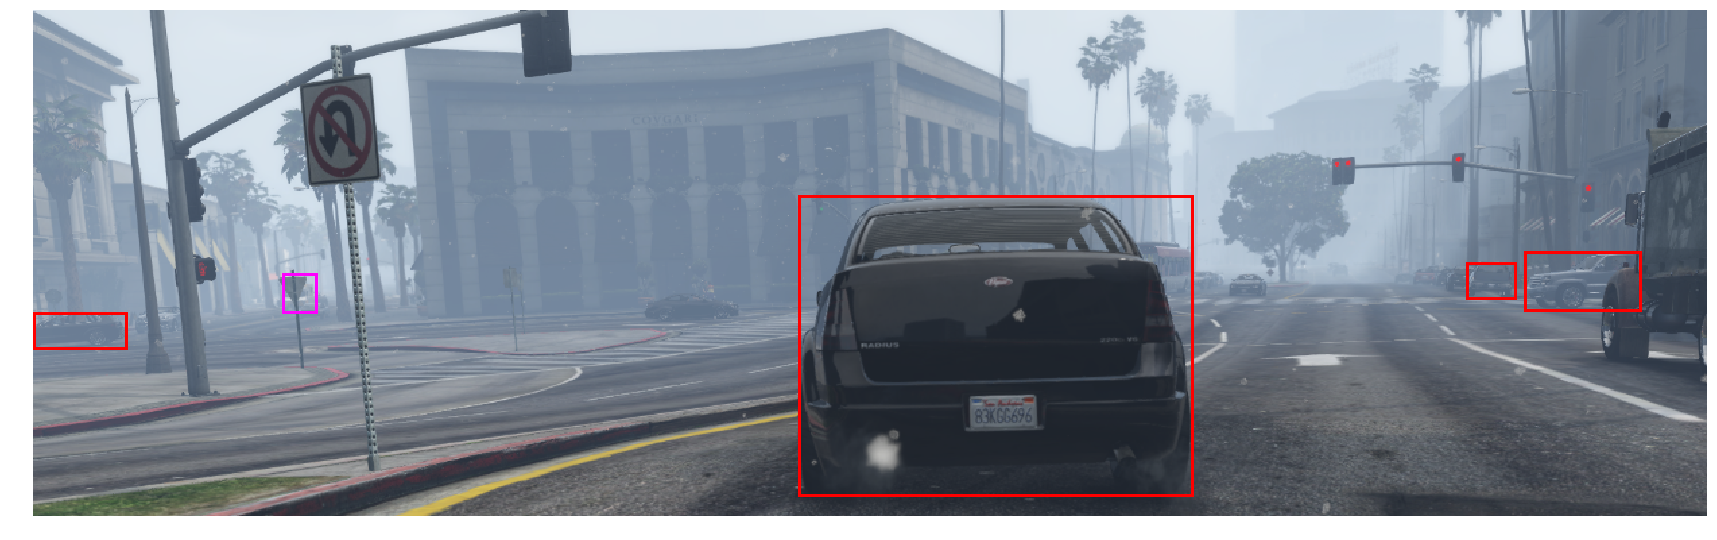

036_01164.png[train]:


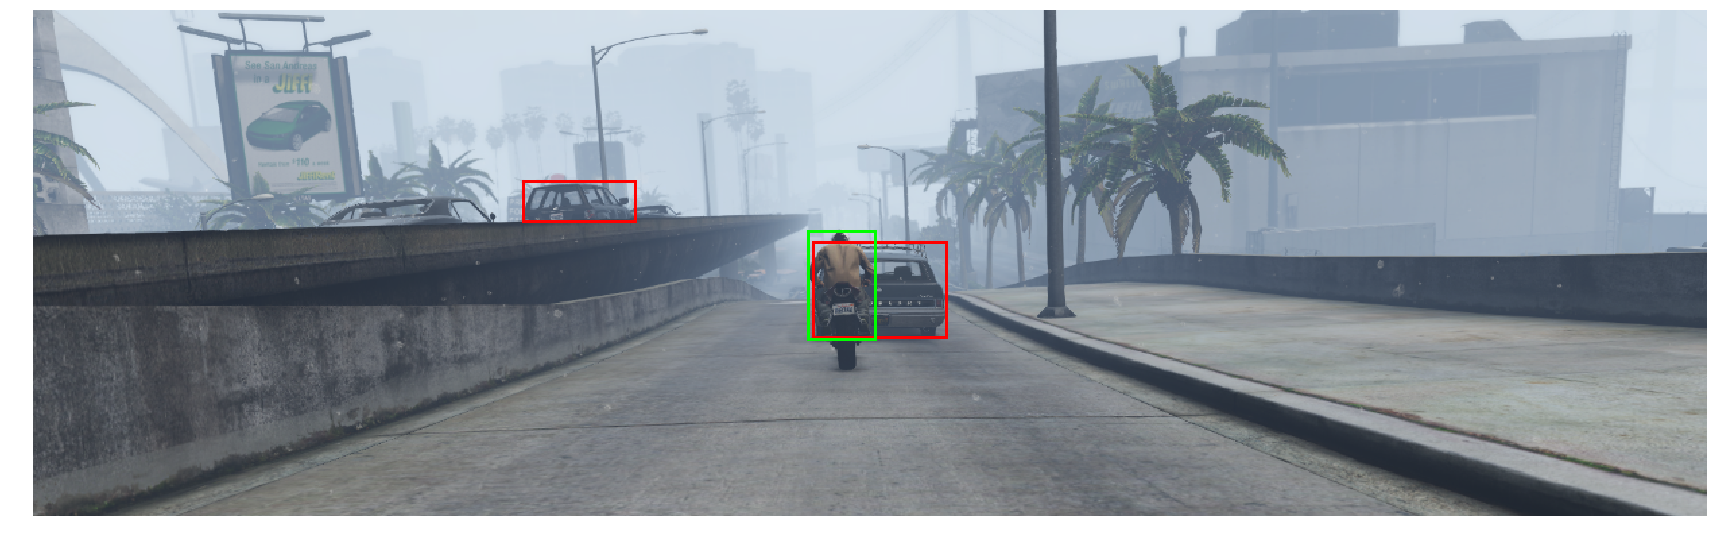

034_00273.png[train]:


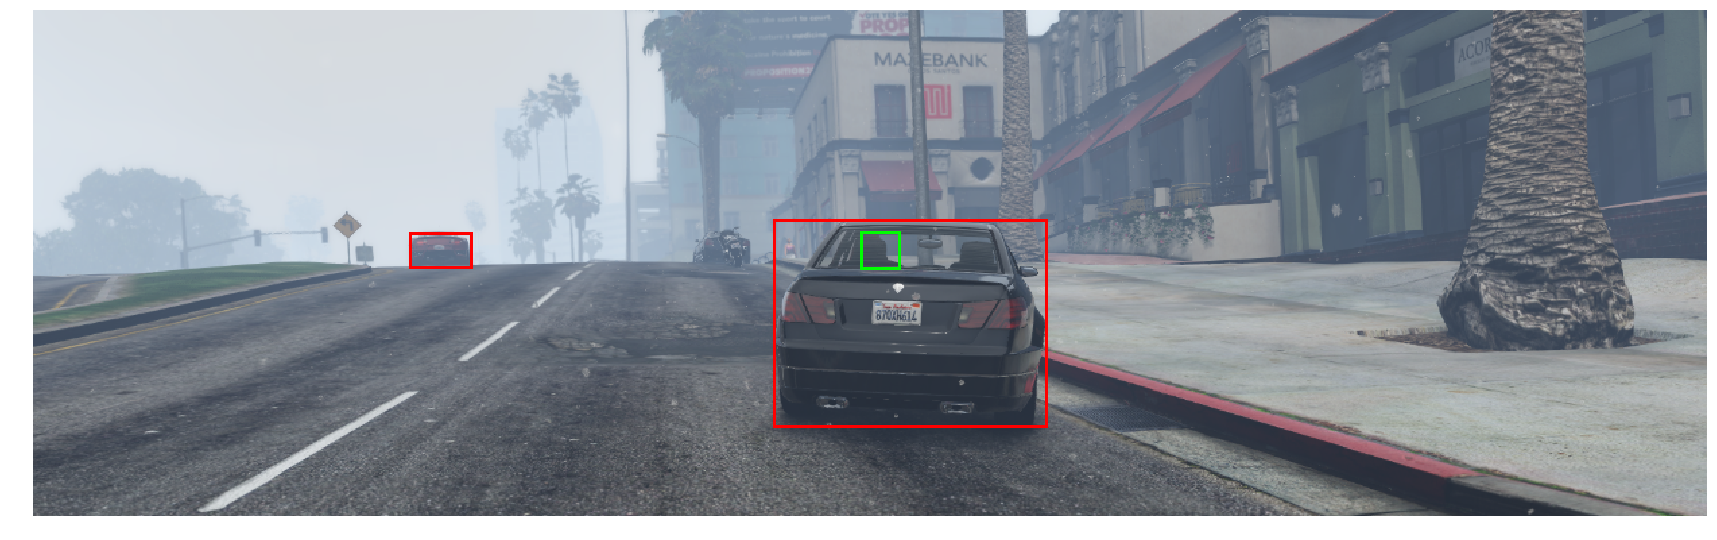

034_00161.png[train]:


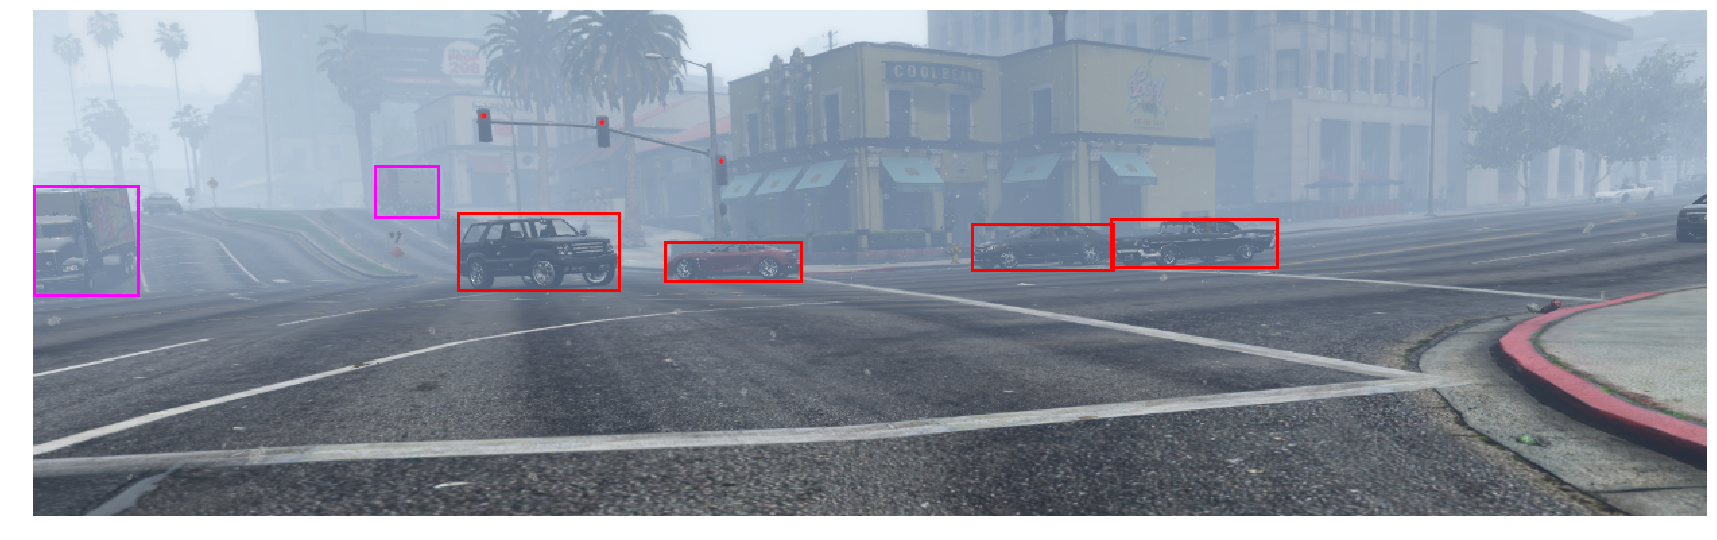

034_00745.png[train]:


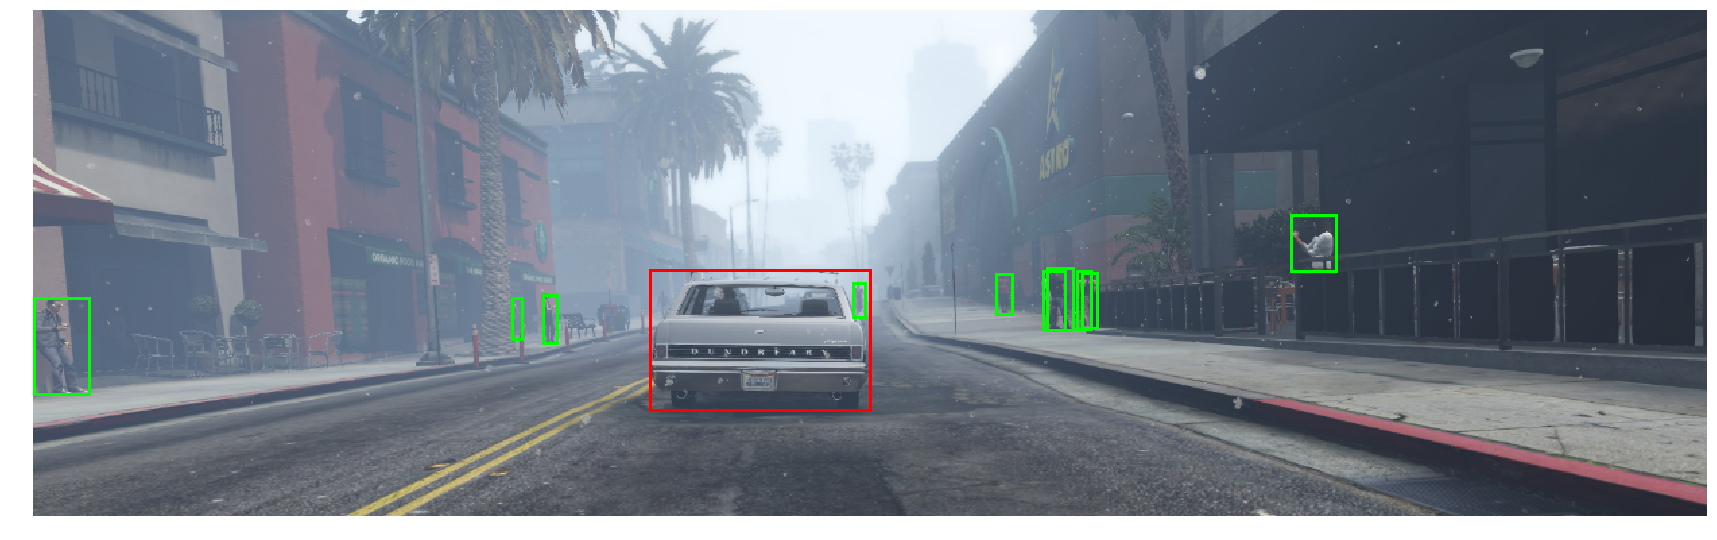

In [214]:
TYPES_TO_DISPLAY = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram']

list_lbl = sample(labels, 10)

for lbl_info in list_lbl:
    
    im_name = lbl_info['filename']
    
    if lbl_info['set'] == 'val':
        path_img = v_path_img
    else:
        path_img = t_path_img
        
    im_path = path.join(path_img, im_name[:3], im_name)
    
    print(im_name + '[' + lbl_info['set'] + ']:')
    
    im_ = imread(im_path)
    im = cv2.resize(im_, (res_img_dim[1], res_img_dim[0]))[crop_y[0]:crop_y[1], :, :]
    
    im_labels = lbl_info['bboxes']

    display_im(im, im_labels, types_to_display = TYPES_TO_DISPLAY, display_info = False, display_center_boxes = False)

## Create the Dataset

In [212]:
# Load json file containing all the labels
labels = json.load(open(export_json_file))

In [216]:
labels = labels[:10]  # DEBUG

# Default values for fields (from writeLabels.m in KITTI devkit_object)
truncation = '-1'
occlusion = '-1'
alpha = '-10'

default_str_bbox = truncation + ' ' + occlusion + ' ' + alpha

h_3D = '-1'
w_3D = '-1'
l_3D = '-1'
t_3D = '-1000 -1000 -1000'
ry_3D = '-10'
score = ''  # Score is empty for training dataset

default_str_end = h_3D + ' ' + w_3D + ' ' + l_3D + ' ' + t_3D + ' ' + ry_3D + ' ' + score

# Create folder to save images and labels
export_folder = path.join(path_export_folder, name_export_folder)
os.makedirs(export_folder)

# Create subfolder to save images
export_folder_im = path.join(export_folder, 'images')
os.makedirs(export_folder_im)

# Create subfolder to save labels
export_folder_lb = path.join(export_folder, 'labels')
os.makedirs(export_folder_lb)

print('-> Creating new dataset:')
print(' \'-> Images will be saved in \'' + export_folder_im + '\'.')
print(' \'-> Labels will be saved in \'' + export_folder_lb + '\'.')

for im_id in tqdm.trange(len(labels), ascii = True):    
    # Get info on the image and its label
    im_info = labels[im_id]
    
    # Import image
    im_name = im_info['filename']
    im_set = im_info['set']
    
    if im_set == 'val':
        import_folder_im = v_path_img
        set_suffixe = 'v_'
    else:
        import_folder_im = t_path_img
        set_suffixe = 't_'
        
    im_path = path.join(import_folder_im, im_name[:3], im_name)
    
    im_ = imread(im_path)
    im = cv2.resize(im_, (res_img_dim[1], res_img_dim[0]))[crop_y[0]:crop_y[1], :, :]
    
    im_export = path.join(export_folder_im, set_suffixe + im_name)
    imwrite(im_export, im)
    
    # labels
    lb_list = im_info['bboxes']
    lb_export = path.join(export_folder_lb, set_suffixe + im_name[:-4] + '.txt')
    
    with open(lb_export, "w") as text_file:
        for lb in lb_list:
            str_bbox_dim = str(lb['bbox']['x_min']) + ' ' + str(lb['bbox']['y_min']) + ' ' + str(lb['bbox']['x_max']) + ' ' + str(lb['bbox']['y_max'])
            str_lb = lb['type'] + ' ' + default_str_bbox + ' ' + str_bbox_dim + ' ' + default_str_end + '\n'
            text_file.write(str_lb)

print('-> SUCCESS: Dataset ready in \'' + export_folder + '\'.')

  0%|          | 0/10 [00:00<?, ?it/s]

-> Creating new dataset:
 '-> Images will be saved in '/Users/lucas/Desktop/gta_dataset_export/images'.
 '-> Labels will be saved in '/Users/lucas/Desktop/gta_dataset_export/labels'.


100%|##########| 10/10 [00:14<00:00,  1.43s/it]

-> SUCCESS: Export is finished in folder '/Users/lucas/Desktop/gta_dataset_export'.
